# Ocena modeli dystrybucyjnych dla korpusu pełnego i wzorcowego

In [38]:
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import string
from pprint import pprint
import token
import numpy as np
from nltk.tokenize import word_tokenize
import warnings
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.exceptions import ConvergenceWarning

from gensim.models import Word2Vec
from gensim.models import FastText

from src.settings import POLISH_ANNOTATIONS_FPATH, DATA_DIR, MODELS_DIR, PLOTS_DIR

tqdm.pandas()

ImportError: cannot import name 'PLOTS_DIR' from 'src.settings' (/app/src/settings.py)

In [2]:
RANDOM_STATE = 42

EMB_VECTOR_SIZE = 100
EMB_WINDOW = 5
VOCAB_MIN_COUNT = 5

MIN_N_GRAM = 1
MAX_N_GRAM = 4

N_FOLDS = 5

EMB_EPOCHS = 20

In [3]:
def preprocess(text, stopwords):
    text = text.lower()
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text, language="polish")
    tokens = [word for word in tokens if word not in stopwords]
    if not any(tokens):
        return np.nan
    return " ".join(tokens)

with open(DATA_DIR / "polish.stopwords.txt", "r") as f:
    stop_words = set(f.readlines())

## Korpus pełny

In [4]:
korpus_pelny = pd.read_csv(DATA_DIR / "all_calls_texts_per_channel.csv")
korpus_pelny

,Unnamed: 0,text,channel,source_file,call
0,1,(yy) Dzień... dzień dobry pani. (yy) Ja dzwoni...,clnt,cbiz_tc_1.clnt.txt,cbiz_tc_1
1,2,"(...) Dobry, Anna Kwiatkowska, Nowy Bank. W cz...",cbiz_tc_1,cbiz_tc_1.txt,cbiz_tc_1
2,3,Kwiatkowska. Przychodnia MedMed. W czym mogę p...,agnt,cbiz_tc_10.agnt.txt,cbiz_tc_10
3,4,"Dzień dobry pani. Ja tutaj zadzwonię do pani, ...",clnt,cbiz_tc_10.clnt.txt,cbiz_tc_10
4,5,Kwiatkowska. Przychodnia MedMed. W czym mogę p...,cbiz_tc_10,cbiz_tc_10.txt,cbiz_tc_10
...,...,...,...,...,...
12024,12025,"(yy) Dzień dobry. Proszę pana, (yy) nie mogę s...",clnt,cbiz_tc_994.clnt.txt,cbiz_tc_994
12025,12026,Dzień dobry. Mikołaj Dębek. Biuro obsługi klie...,cbiz_tc_994,cbiz_tc_994.txt,cbiz_tc_994
12026,12027,"Dzień dobry, Andrzej Kwaśniak, Biuro Obsługi K...",agnt,cbiz_tc_995.agnt.txt,cbiz_tc_995
12027,12028,"(yy) Dzień dobry, Michał Flagowy z tej strony....",clnt,cbiz_tc_995.clnt.txt,cbiz_tc_995


In [5]:
korpus_pelny["text"].isna().sum()

0

In [6]:
korpus_pelny_preprocessed = korpus_pelny.copy()
korpus_pelny_preprocessed["text"] = korpus_pelny_preprocessed["text"].progress_apply(preprocess, args=(stop_words,))

korpus_pelny_preprocessed["text"][5]

  0%|          | 0/12029 [00:00<?, ?it/s]

'dzień dobry karolina adamczyk telekom sa w czym mogę pomóc oczywiście już wszystko sprawdzimy chciałam się tylko dowiedzieć yy czy to jest ten numer telefonu z którego pani dzwoni tak dobrze prosiłabym jeszcze o hasło abonenckie dobrze to w takim razie może inaczej jest pani właścicielem tego numeru tak dobrze to prosiłabym w takim razie o numer pesel i adres zameldowania sześćdziesiąt cztery tak tak siedem czy jeden przepraszam siedem dobrze tak czterysta sześćdziesiąt dobrze i jeszcze adres zameldowania ludowa tak dwadzieścia osiem tak siemianowice śląskie yy dobrze proszę jeszcze dać dać chwilkę system wczyta dane dobrze yy proszę mi jeszcze powiedzieć jak proszę mi jeszcze powiedzieć jak rozumiem w ustawieniach tryb sieci tak aha dobrze wie pani co to spróbujemy zrobić reset w takim razie i powinno pomóc w tej sytuacji prosiłabym rozłączyć internet i spróbować się połączyć ponownie za około piętnaście minut być może to już wcześniej się włączy mogę pani jeszcze jakoś pomóc dobrze 

In [7]:
pelny_tokens = [
    token
    for tokens in np.char.split(korpus_pelny_preprocessed[["text"]].to_numpy().flatten().astype("str"))
    for token in tokens
]

len(pelny_tokens), pelny_tokens[:5]

(6674344, ['yy', 'dzień', 'dzień', 'dobry', 'pani'])

## Zbiór danych do klasyfikacji (tekst - numer zadania), korpus wzorcowy

In [8]:
korpus_wzorcowy = pd.read_json(POLISH_ANNOTATIONS_FPATH, lines=True)
korpus_wzorcowy

,start,end,text,doc_filepath,video_filename,task_label
0,39040,41120,"Myślę, że mam inny pomysł, można?",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
1,41120,49680,"Chyba ten znak mówi, że jak ktoś będzie spacer...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
2,49680,55280,Trzeba przejść łukiem obok leżącego i o tym zn...,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
3,61280,66840,"Okrągły znak pomaga nam, mówi, że są pasy na u...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
4,66840,73200,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
...,...,...,...,...,...,...
40350,248960,250320,[uderzanie w coś],/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13
40351,279560,291400,Kot zobaczył w akwarium rybkę. Podszedł i dał ...,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13
40352,291400,347120,"Zjadłam, zjadłam.",/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13
40353,347120,356440,"Zając biegnie, zobaczył wiszące pranie. Wskocz...",/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13


In [9]:
target_labels = korpus_wzorcowy["task_label"].astype(str).unique().tolist()
target_labels

['15', '24', '7', '17', '8', '13']

In [10]:
korpus_wzorcowy["text"].isna().sum(), korpus_wzorcowy["task_label"].isna().sum()

(0, 0)

In [11]:
korpus_wzorcowy_preprocessed = korpus_wzorcowy.copy()
korpus_wzorcowy_preprocessed["text"] = korpus_wzorcowy_preprocessed["text"].apply(preprocess, args=(stop_words,))

korpus_wzorcowy_preprocessed["text"][5]

'ktoś biega bez świadomości i może spowodować wypadek a znak nam pomaga przypomina żeby uważać'

In [12]:
korpus_wzorcowy_preprocessed.isna().sum()

start             0
end               0
text              2
doc_filepath      0
video_filename    0
task_label        0
dtype: int64

In [13]:
pl_data_preprocessed = korpus_wzorcowy_preprocessed.dropna()
pl_data_preprocessed.shape

(40353, 6)

In [14]:
wzorcowy_X, wzorcowy_y = pl_data_preprocessed[["text"]].to_numpy(), pl_data_preprocessed["task_label"].to_numpy()

In [15]:
wzorcowy_tokens = [
    token
    for tokens in np.char.split(wzorcowy_X.flatten().astype("str"))
    for token in tokens
]
wzorcowy_tokens[:3]

['myślę', 'że', 'mam']

## Modele dystrybucyjne

In [16]:
def get_embedding_models():
    return [
        Word2Vec(sg=1, vector_size=EMB_VECTOR_SIZE, window=EMB_WINDOW, min_count=VOCAB_MIN_COUNT, workers=4),
        Word2Vec(sg=0, vector_size=EMB_VECTOR_SIZE, window=EMB_WINDOW, min_count=VOCAB_MIN_COUNT, workers=4),
        FastText(sg=1, vector_size=EMB_VECTOR_SIZE, window=EMB_WINDOW, min_count=VOCAB_MIN_COUNT, min_n=MIN_N_GRAM, max_n=MAX_N_GRAM, workers=4),
        FastText(sg=0, vector_size=EMB_VECTOR_SIZE, window=EMB_WINDOW, min_count=VOCAB_MIN_COUNT, min_n=MIN_N_GRAM, max_n=MAX_N_GRAM, workers=4),
    ]

def get_emb_model_name(emb_model, safe=False):
    alg = "Skip-gram" if emb_model.sg == 1 else "CBOW"
    if safe:
        return f"{emb_model.__class__.__name__}_{alg}".replace("-", "_")
    return f"{emb_model.__class__.__name__} ({alg})"

In [17]:
wzorcowy_emb_models = get_embedding_models()
pelny_emb_models = get_embedding_models()

### Build vocabulary

In [18]:
for wzorcowy_emb_model, pelny_emb_model in tqdm(list(zip(wzorcowy_emb_models, pelny_emb_models))):
    wzorcowy_emb_model.build_vocab(wzorcowy_tokens)
    pelny_emb_model.build_vocab(pelny_tokens)
    wzorcowy_emb_model_name = get_emb_model_name(wzorcowy_emb_model)
    pelny_emb_model_name = get_emb_model_name(pelny_emb_model)
    print("Korpus wzorcowy | ", wzorcowy_emb_model_name, len(wzorcowy_emb_model.wv))
    print("Korpus pełny | ", pelny_emb_model_name, len(pelny_emb_model.wv))

  0%|          | 0/4 [00:00<?, ?it/s]

Korpus wzorcowy |  Word2Vec (Skip-gram) 44
Korpus pełny |  Word2Vec (Skip-gram) 49
Korpus wzorcowy |  Word2Vec (CBOW) 44
Korpus pełny |  Word2Vec (CBOW) 49
Korpus wzorcowy |  FastText (Skip-gram) 44
Korpus pełny |  FastText (Skip-gram) 49
Korpus wzorcowy |  FastText (CBOW) 44
Korpus pełny |  FastText (CBOW) 49


### Train embedding models

In [19]:
num_wzorcowy_tokens = len(wzorcowy_tokens)
num_pelny_tokens = len(pelny_tokens)
for wzorcowy_emb_model, pelny_emb_model in tqdm(list(zip(wzorcowy_emb_models, pelny_emb_models))):
    wzorcowy_emb_model.train(wzorcowy_tokens, total_examples=num_wzorcowy_tokens, epochs=EMB_EPOCHS)
    pelny_emb_model.train(pelny_tokens, total_examples=num_pelny_tokens, epochs=EMB_EPOCHS)

  0%|          | 0/4 [00:00<?, ?it/s]

### Dump ebemdding models

In [ ]:
for wzorcowy_emb_model, pelny_emb_model in tqdm(list(zip(wzorcowy_emb_models, pelny_emb_models))):
    wzorcowy_emb_model.save(str(MODELS_DIR / f"wzorcowy_{get_emb_model_name(wzorcowy_emb_model, safe=True)}.model"))
    pelny_emb_model.save(str(MODELS_DIR / f"pelny_{get_emb_model_name(pelny_emb_model, safe=True)}.model"))

### Load embedding models

In [18]:
wzorcowy_emb_models, pelny_emb_models = [], []
for emb_model_path in MODELS_DIR.glob("*.model"):
    model_base_class = Word2Vec if "Word2Vec" in emb_model_path.name else FastText
    emb_model = model_base_class.load(str(emb_model_path))
    if emb_model_path.name.startswith("wzorcowy"):
        wzorcowy_emb_models.append(emb_model)
    else:
        pelny_emb_models.append(emb_model)

wzorcowy_emb_models, pelny_emb_models

([<gensim.models.fasttext.FastText at 0x7fb2ec44f2b0>,
  <gensim.models.fasttext.FastText at 0x7fb26156e800>])

In [19]:
def vectorize(sentence, emb_model):
    words = sentence.split()
    words_vecs = [emb_model.wv[word] for word in words if word in emb_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

def vectorize_data(X, emb_model):
    return np.array([vectorize(sentence, emb_model) for sentence in X])

In [20]:
def evaluate_clf(clf, X_test, y_test, target_names=None):
    y_pred = clf.predict(X_test)
    return classification_report(y_test, y_pred, output_dict=False, target_names=target_names, zero_division=0, digits=4)

In [21]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)


X, y = pl_data_preprocessed["text"].to_numpy(), pl_data_preprocessed["task_label"].to_numpy()

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
]

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

metrics_rows = []
fold_indices_rows = []
for i_emb_model, (wzorcowy_emb_model, pelny_emb_model) in enumerate(list(zip(wzorcowy_emb_models, pelny_emb_models))):
    wzorcowy_X_vecs = vectorize_data(X, wzorcowy_emb_model)
    pelny_X_vecs = vectorize_data(X, pelny_emb_model)
    
    wzorcowy_emb_model_name = get_emb_model_name(wzorcowy_emb_model)
    pelny_emb_model_name = get_emb_model_name(pelny_emb_model)

    for fold, (train_indices, test_indices) in enumerate(skf.split(X, y), start=1):
        wzorcowy_X_train, wzorcowy_y_train = wzorcowy_X_vecs.take(train_indices, axis=0), y.take(train_indices, axis=0)
        wzorcowy_X_test, wzorcowy_y_test = wzorcowy_X_vecs.take(test_indices, axis=0), y.take(test_indices, axis=0)
        
        pelny_X_train, pelny_y_train = pelny_X_vecs.take(train_indices, axis=0), y.take(train_indices, axis=0)
        pelny_X_test, pelny_y_test = pelny_X_vecs.take(test_indices, axis=0), y.take(test_indices, axis=0)

        clfs = classifiers.copy()
        for i_clf, (wzorcowy_clf, pelny_clf) in enumerate(zip(clfs, clfs), start=1):
            clf_name = wzorcowy_clf.__class__.__name__

            wzorcowy_clf.fit(wzorcowy_X_train, wzorcowy_y_train)
            wzorcowy_y_preds = wzorcowy_clf.predict(wzorcowy_X_test)
            wzorcowy_clf_report = classification_report(wzorcowy_y_test, wzorcowy_y_preds, output_dict=True, target_names=target_labels, zero_division=0)

            pelny_clf.fit(pelny_X_train, pelny_y_train)
            pelny_y_preds = pelny_clf.predict(pelny_X_test)
            pelny_clf_report = classification_report(pelny_y_test, pelny_y_preds, output_dict=True, target_names=target_labels, zero_division=0)

            metrics_rows.append({
                "EmbeddingModel": wzorcowy_emb_model_name,
                "Classifier": clf_name,
                "Corpora": "Wzorcowy",
                "CvFold": fold,
                "Accuracy": wzorcowy_clf_report["accuracy"],
                "F1scoreMacro": wzorcowy_clf_report["macro avg"]["f1-score"],
                "PrecisionMacro": wzorcowy_clf_report["macro avg"]["precision"],
                "RecallMacro": wzorcowy_clf_report["macro avg"]["recall"],
                "Support": wzorcowy_clf_report["macro avg"]["support"],
            })
            metrics_rows.append({
                "EmbeddingModel": pelny_emb_model_name,
                "Classifier": clf_name,
                "Corpora": "Pełny",
                "CvFold": fold,
                "Accuracy": pelny_clf_report["accuracy"],
                "F1scoreMacro": pelny_clf_report["macro avg"]["f1-score"],
                "PrecisionMacro": pelny_clf_report["macro avg"]["precision"],
                "RecallMacro": pelny_clf_report["macro avg"]["recall"],
                "Support": pelny_clf_report["macro avg"]["support"],
            })

            print((
                "Embedding model: " + f"{i_emb_model:>2}/{len(wzorcowy_emb_models)}"
                " | Fold: " + f"{fold}/{N_FOLDS}"
                " | Classifier: " + f"{i_clf:>2}/{len(classifiers)}"
            ).ljust(100, " "), end="\r")


print(f"\n\n{datetime.now()} | DONE!")

Embedding model:  3/4 | Fold: 5/5 | Classifier:  3/3                                                

2023-12-08 07:14:45.401573 | DONE!


In [22]:
evaluation_df = pd.DataFrame.from_records(metrics_rows)
evaluation_df

,EmbeddingModel,Classifier,Corpora,CvFold,Accuracy,F1scoreMacro,PrecisionMacro,RecallMacro,Support
0,FastText (Skip-gram),LogisticRegression,Wzorcowy,1,0.421757,0.285132,0.339164,0.303773,8071.0
1,FastText (Skip-gram),LogisticRegression,Pełny,1,0.428571,0.292166,0.355578,0.309879,8071.0
2,FastText (Skip-gram),KNeighborsClassifier,Wzorcowy,1,0.539338,0.479969,0.505776,0.468394,8071.0
3,FastText (Skip-gram),KNeighborsClassifier,Pełny,1,0.534382,0.476788,0.497639,0.466549,8071.0
4,FastText (Skip-gram),DecisionTreeClassifier,Wzorcowy,1,0.452236,0.387551,0.387699,0.387476,8071.0
...,...,...,...,...,...,...,...,...,...
115,FastText (CBOW),LogisticRegression,Pełny,5,0.438166,0.313461,0.360053,0.326644,8070.0
116,FastText (CBOW),KNeighborsClassifier,Wzorcowy,5,0.520322,0.458557,0.484395,0.447704,8070.0
117,FastText (CBOW),KNeighborsClassifier,Pełny,5,0.502230,0.437848,0.460123,0.428751,8070.0
118,FastText (CBOW),DecisionTreeClassifier,Wzorcowy,5,0.441636,0.381129,0.382168,0.380375,8070.0


In [23]:
evaluation_df.to_csv(DATA_DIR / "nlp_lab_9_clf_evaluation.csv", index=False)

In [ ]:
evaluation_df = pd.read_csv(DATA_DIR / "nlp_lab_9_clf_evaluation.csv")

In [24]:
XTICKS_ROTATION = 0

# Adding score values on top of each bar

def add_bar_labels(ax):
    """
    Add labels on top of each bar in seaborn barplot.
    """
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + (p.get_height() * 0.8)
        value = '{:.3f}'.format(p.get_height())
        if value == '{:.3f}'.format(0):
            continue
        ax.text(_x, _y, value, ha="center", va='bottom', fontsize=8)

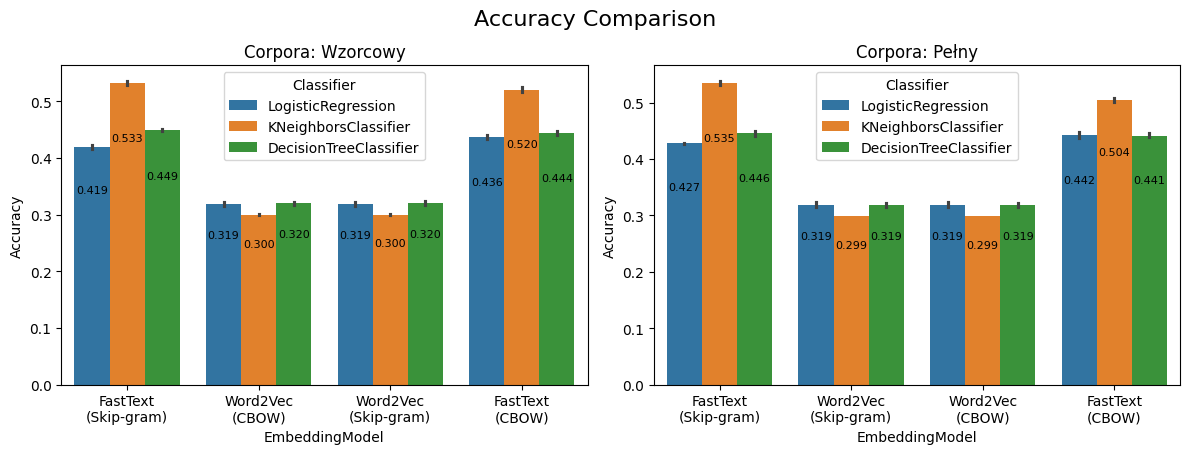

In [51]:
wzorcowy_df = evaluation_df[evaluation_df.Corpora == "Wzorcowy"].copy()
pelny_df = evaluation_df[evaluation_df.Corpora == "Pełny"].copy()
wzorcowy_df["EmbeddingModel"] = wzorcowy_df["EmbeddingModel"].str.replace(" (", "\n(")
pelny_df["EmbeddingModel"] = pelny_df["EmbeddingModel"].str.replace(" (", "\n(")


# Plotting with score values
fig = plt.figure(figsize=(12, 8))

# Plot for Accuracy
ax1 = plt.subplot(2, 2, 1)
sns.barplot(data=wzorcowy_df, x='EmbeddingModel', y='Accuracy', hue='Classifier', ax=ax1)
plt.title('Corpora: Wzorcowy')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(ax1)

ax2 = plt.subplot(2, 2, 2)
sns.barplot(data=pelny_df, x='EmbeddingModel', y='Accuracy', hue='Classifier', ax=ax2)
plt.title('Corpora: Pełny')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(ax2)

fig.suptitle("Accuracy Comparison", fontsize=16)

plt.tight_layout()
plt.show()

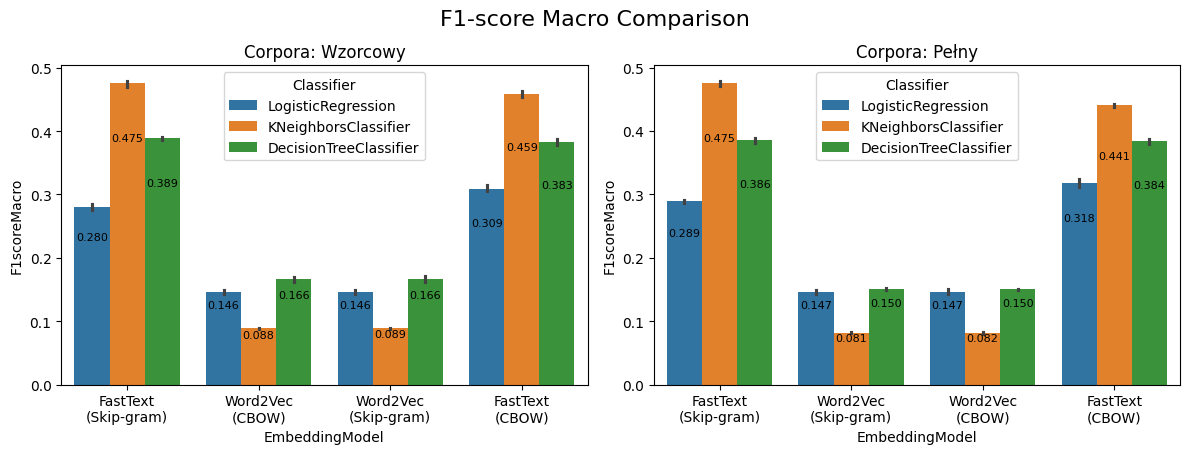

In [52]:
# Plotting with score values
fig = plt.figure(figsize=(12, 8))

# Plot for Accuracy
ax1 = plt.subplot(2, 2, 1)
sns.barplot(data=wzorcowy_df, x='EmbeddingModel', y='F1scoreMacro', hue='Classifier', ax=ax1)
plt.title('Corpora: Wzorcowy')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(ax1)

ax2 = plt.subplot(2, 2, 2)
sns.barplot(data=pelny_df, x='EmbeddingModel', y='F1scoreMacro', hue='Classifier', ax=ax2)
plt.title('Corpora: Pełny')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(ax2)

fig.suptitle("F1-score Macro Comparison", fontsize=16)

plt.tight_layout()
plt.show()

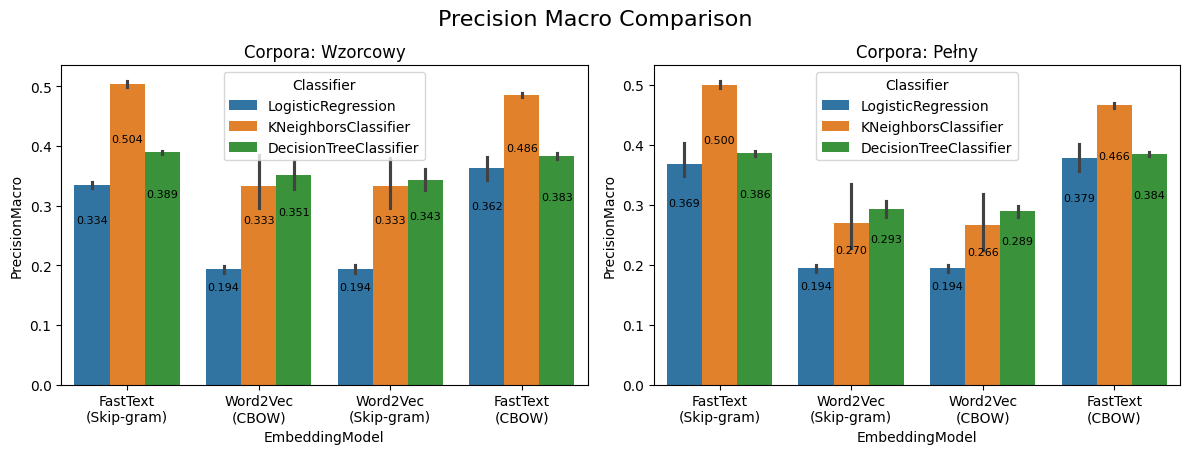

In [53]:
# Plotting with score values
fig = plt.figure(figsize=(12, 8))

# Plot for Accuracy
ax1 = plt.subplot(2, 2, 1)
sns.barplot(data=wzorcowy_df, x='EmbeddingModel', y='PrecisionMacro', hue='Classifier', ax=ax1)
plt.title('Corpora: Wzorcowy')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(ax1)

ax2 = plt.subplot(2, 2, 2)
sns.barplot(data=pelny_df, x='EmbeddingModel', y='PrecisionMacro', hue='Classifier', ax=ax2)
plt.title('Corpora: Pełny')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(ax2)

fig.suptitle("Precision Macro Comparison", fontsize=16)

plt.tight_layout()
plt.show()

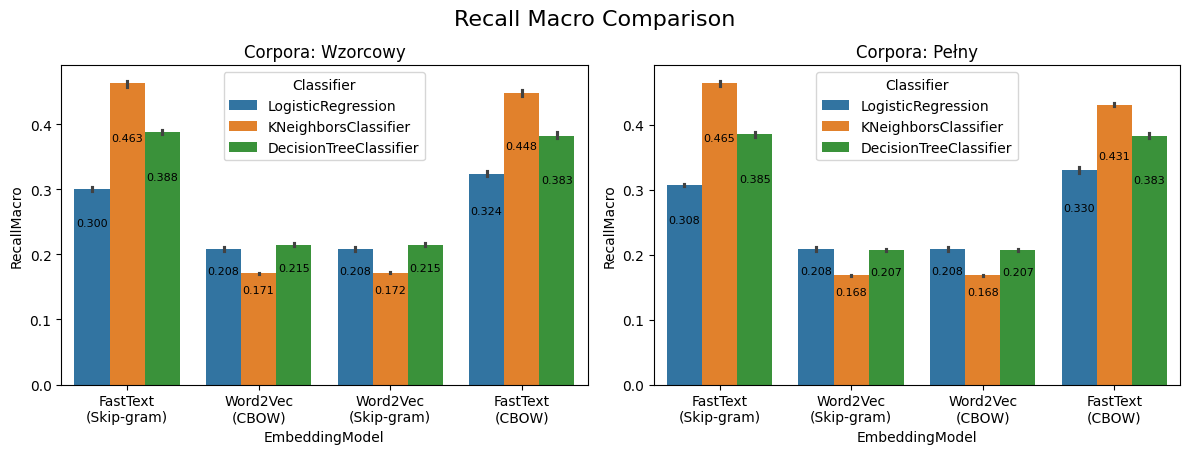

In [54]:
# Plotting with score values
fig = plt.figure(figsize=(12, 8))

# Plot for Accuracy
ax1 = plt.subplot(2, 2, 1)
sns.barplot(data=wzorcowy_df, x='EmbeddingModel', y='RecallMacro', hue='Classifier', ax=ax1)
plt.title('Corpora: Wzorcowy')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(ax1)

ax2 = plt.subplot(2, 2, 2)
sns.barplot(data=pelny_df, x='EmbeddingModel', y='RecallMacro', hue='Classifier', ax=ax2)
plt.title('Corpora: Pełny')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(ax2)

fig.suptitle("Recall Macro Comparison", fontsize=16)

plt.tight_layout()
plt.show()